In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')

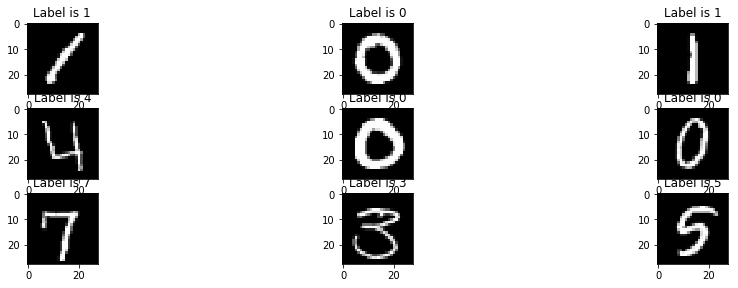

In [3]:
## Create a Function for visualization of MNIST dataset
def visualize_mnist(pixels, labels, ncol):
    n = len(labels)
    nrow = (n//ncol + 1)
    fig = plt.figure(figsize=(nrow * 4, ncol * 2))
    for cnt in range(n):
        label = labels[cnt]
        pix = np.array(pixels.iloc[cnt,:], dtype='uint8')
        pix = pix.reshape((28, 28))
        ax1 = fig.add_subplot(nrow, ncol, cnt+1)
        ax1.set_title('Label is {label}'.format(label=label))
        ax1.imshow(pix, cmap='gray')
items = raw_train[:9]
visualize_mnist(items.iloc[:, 1:], items.iloc[:, 0], 3)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

XX = np.array(raw_train.iloc[:, 1:])
YY_ = np.array(raw_train.iloc[:, 0:1])
ohe = OneHotEncoder(sparse=False, categories='auto').fit(YY_)
YY = ohe.transform(YY_)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XX, YY, test_size=0.2, random_state=15)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(33600, 784) (8400, 784) (33600, 10) (8400, 10)


In [5]:
uni, cnt = np.unique(ohe.inverse_transform(Ytrain), return_counts=True)
print('The training set has %s numbers with %s frequencies'%(uni, cnt))
uni, cnt = np.unique(ohe.inverse_transform(Ytest), return_counts=True)
print('The testing set has %s numbers with %s frequencies'%(uni, cnt))

The training set has [0 1 2 3 4 5 6 7 8 9] numbers with [3332 3764 3355 3512 3248 3000 3305 3493 3262 3329] frequencies
The testing set has [0 1 2 3 4 5 6 7 8 9] numbers with [800 920 822 839 824 795 832 908 801 859] frequencies


### Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score, \
                            cohen_kappa_score, confusion_matrix
rf = RandomForestClassifier(n_estimators=20, max_depth=32, criterion='entropy', random_state=2)
rf.fit(Xtrain, ohe.inverse_transform(Ytrain))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [34]:
Ypred = rf.predict(Xtest)
Ytest_ = ohe.inverse_transform(Ytest)
#Ypred_ = ohe.inverse_transform(Ypred)
print(confusion_matrix(Ytest_, Ypred))
print(classification_report(Ytest_, Ypred))

[[787   0   2   0   0   1   6   0   4   0]
 [  0 907   5   3   0   1   1   0   2   1]
 [  4   4 792   6   2   1   4   6   2   1]
 [  0   0  12 798   0  10   3   2  12   2]
 [  2   3   1   0 793   0   5   1   2  17]
 [  6   1   0  18   1 748  12   0   5   4]
 [  6   0   3   0   2  11 807   0   3   0]
 [  0   5  11   0  10   0   0 868   0  14]
 [  4   4  10  15   6   9   6   2 732  13]
 [  6   4   4  12  19   6   1   9   6 792]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       800
           1       0.98      0.99      0.98       920
           2       0.94      0.96      0.95       822
           3       0.94      0.95      0.94       839
           4       0.95      0.96      0.96       824
           5       0.95      0.94      0.95       795
           6       0.96      0.97      0.96       832
           7       0.98      0.96      0.97       908
           8       0.95      0.91      0.93       801
           9       0.94     

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score, \
                            cohen_kappa_score, confusion_matrix
rf = RandomForestClassifier(n_estimators=20, max_depth=32, criterion='entropy', random_state=2)
rf.fit(Xtrain, ohe.inverse_transform Ytrain)

### XGBoost

In [31]:
import xgboost as xgb
dtrain = xgb.DMatrix(data=Xtrain, label=ohe.inverse_transform(Ytrain))
params = {
    'max_depth': 32,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 10,
    'n_gpus': 0
}
xgbt = xgb.train(params, dtrain)

In [32]:
Ypred = xgbt.predict(xgb.DMatrix(data=Xtest))
Ytest_ = ohe.inverse_transform(Ytest)
print(confusion_matrix(Ytest_, Ypred))
print(classification_report(Ytest_, Ypred))

[[780   0   1   2   1   3   3   0   6   4]
 [  0 904   3   4   2   0   3   1   3   0]
 [  6   4 789   6   2   0   3   7   4   1]
 [  1   3  16 790   1   7   1   5   7   8]
 [  2   3   1   0 785   1   3   1   4  24]
 [  2   0   2   8   2 755  10   4   7   5]
 [  6   1   0   0   4   9 802   0  10   0]
 [  0   8  10   3   2   0   1 864   3  17]
 [  4   5   7  10   2   9   7   1 743  13]
 [  5   2   3   9   6   6   0  10   7 811]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       800
           1       0.97      0.98      0.98       920
           2       0.95      0.96      0.95       822
           3       0.95      0.94      0.95       839
           4       0.97      0.95      0.96       824
           5       0.96      0.95      0.95       795
           6       0.96      0.96      0.96       832
           7       0.97      0.95      0.96       908
           8       0.94      0.93      0.93       801
           9       0.92     

### Neural Networks

In [7]:
# Hyper-parameters
epochs = 10             # Total number of training epochs
batch_size = 200         # Training batch size
display_freq = 100      # Frequency of displaying the training results
learning_rate = 0.001   # The optimization initial learning rate

# Network Parameters
n_hidden_1 = 400 # 1st layer number of neurons
n_hidden_2 = 150 # 2nd layer number of neurons
n_hidden_3 = 32
n_input = 784 # MNIST data input (img shape: 28*28)
n_class = 10 # MNIST total classes (0-9 digits)

In [8]:
# Input and Output
X = tf.placeholder(tf.float32, shape=[None, n_input], name='X')
Y = tf.placeholder(tf.float32, shape=[None, n_class], name='Y')

# Create the NN Structure
W1 = tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=0.35, seed=1), name="W1")
b1 = tf.Variable(tf.zeros([n_hidden_1]), name="B1")
l1 = tf.nn.relu(tf.matmul(X, W1) + b1)

W2 = tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=0.35, seed=2), name="W2")
b2 = tf.Variable(tf.zeros([n_hidden_2]), name="B2")
l2 = tf.nn.relu(tf.matmul(l1, W2) + b2)

# W3 = tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], stddev=0.35, seed=16), name="W3")
# b3 = tf.Variable(tf.zeros([n_hidden_3]), name="B3")
# l3 = tf.nn.sigmoid(tf.matmul(l2, W3) + b3)

W4 = tf.Variable(tf.random_normal([n_hidden_2, n_class], stddev=0.35, seed=3), name="W4")
b4 = tf.Variable(tf.zeros([n_class]), name="B4")
output = tf.matmul(l2, W4) + b4

# Minimize error using cross entropy
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=Y, name='cost'))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output, 1), tf.argmax(Y, 1)), tf.float32), name='accuracy')

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
def next_batch(X_, Y_, random=False, indices=None, size=None):
    if random:
        indices = np.random.choice(X_.shape[0], size, replace=False)
    return X_[indices], Y_[indices]
    

with tf.Session() as sess:
    sess.run(init)
    global_step = 0
    # Number of training iterations in each epoch
    num_tr_iter = len(Ytrain) // batch_size
    for epoch in range(epochs):
        print('Training epoch: {}'.format(epoch + 1))
        for iteration in range(num_tr_iter):
            global_step += 1
            start = iteration * batch_size
            end = min((iteration + 1) * batch_size, len(Ytrain))
            x_batch, y_batch = next_batch(Xtrain, Ytrain, random=False, indices=range(start,end), size=batch_size)

            # Run optimization op (backprop)
            sess.run(optimizer, feed_dict={X: x_batch, Y: y_batch})

#             if iteration % display_freq == 0:
#                 # Calculate and display the batch loss and accuracy
#                 cost_batch, acc_batch = sess.run([cost, accuracy], feed_dict={X: x_batch, Y: y_batch})
#                 print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".format(iteration, cost_batch, acc_batch))

        # Run validation after every epoch
        cost_train, acc_train = sess.run([cost, accuracy], feed_dict={X: x_batch, Y: y_batch})
        cost_valid, acc_valid = sess.run([cost, accuracy], feed_dict={X: Xtest, Y: Ytest})     
        print("Epoch: {0}, training loss: {1:.2f}, training accuracy: {2:.01%}".format(epoch + 1, cost_train, acc_train))
        print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".format(epoch + 1, cost_valid, acc_valid))
        print('---------------------------------------------------------')

Training epoch: 1
Epoch: 1, training loss: 457.01, training accuracy: 86.0%
Epoch: 1, validation loss: 446.49, validation accuracy: 87.2%
---------------------------------------------------------
Training epoch: 2
Epoch: 2, training loss: 215.97, training accuracy: 92.0%
Epoch: 2, validation loss: 291.55, validation accuracy: 90.1%
---------------------------------------------------------
Training epoch: 3
Epoch: 3, training loss: 111.54, training accuracy: 95.0%
Epoch: 3, validation loss: 233.45, validation accuracy: 91.2%
---------------------------------------------------------
Training epoch: 4
Epoch: 4, training loss: 58.57, training accuracy: 96.0%
Epoch: 4, validation loss: 204.90, validation accuracy: 91.9%
---------------------------------------------------------
Training epoch: 5
Epoch: 5, training loss: 29.28, training accuracy: 98.0%
Epoch: 5, validation loss: 183.67, validation accuracy: 92.3%
---------------------------------------------------------
Training epoch: 6
Epoc

In [10]:
import keras

## Create Model
model = keras.Sequential()
model.add(keras.layers.Dense(n_hidden_1, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.35, seed=13), input_shape=(n_input,)))
model.add(keras.layers.Dense(n_hidden_2, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.35, seed=15)))
model.add(keras.layers.Dense(n_class, activation=tf.nn.softmax, kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.35, seed=17)))

model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(Xtrain, Ytrain, validation_data=[Xtest, Ytest], batch_size=batch_size, epochs=epochs)

Instructions for updating:
Use tf.cast instead.


Using TensorFlow backend.


Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 2s 45us/step - loss: 14.2436 - acc: 0.1162 - val_loss: 14.4602 - val_acc: 0.1029
Epoch 2/10
33600/33600 [==============================] - 1s 39us/step - loss: 13.6201 - acc: 0.1549 - val_loss: 12.0924 - val_acc: 0.2498
Epoch 3/10
33600/33600 [==============================] - 1s 41us/step - loss: 12.2322 - acc: 0.2410 - val_loss: 11.8506 - val_acc: 0.2648
Epoch 4/10
33600/33600 [==============================] - 1s 37us/step - loss: 12.5133 - acc: 0.2236 - val_loss: 12.5050 - val_acc: 0.2242
Epoch 5/10
33600/33600 [==============================] - 1s 37us/step - loss: 12.5697 - acc: 0.2201 - val_loss: 12.5050 - val_acc: 0.2242
Epoch 6/10
33600/33600 [==============================] - 1s 36us/step - loss: 12.5697 - acc: 0.2201 - val_loss: 12.5050 - val_acc: 0.2242
Epoch 7/10
33600/33600 [==============================] - 1s 36us/step - loss: 12.5697 - acc: 0.2201 - val_loss: 12.5